In [1]:
# The magic commands below allow reflecting the changes in an imported module without restarting the kernel.
%load_ext autoreload
%autoreload 2


!source /lus/theta-fs0/projects/connectomics_aesp/software/neurmessao_env_36/bin/activate
!/lus/theta-fs0/projects/connectomics_aesp/software/neuro_env_36/bin/python -m ipykernel install --user --name jhub_neurenev36

/bin/sh: /lus/theta-fs0/projects/connectomics_aesp/software/neurmessao_env_36/bin/activate: No such file or directory
/lus/theta-fs0/projects/connectomics_aesp/software/neuro_env_36/bin/python: error while loading shared libraries: libpython3.6m.so.1.0: cannot open shared object file: No such file or directory


In [2]:
# We need to add balsam and the modules it depends on to the Python search paths. 
import sys
sys.path.insert(0,'/soft/datascience/Balsam/0.3.5.1/env/lib/python3.6/site-packages/')
sys.path.insert(0,'/soft/datascience/Balsam/0.3.5.1/')

import matplotlib.pyplot
#sys.path.insert(0,'/lus/theta-fs0/projects/connectomics_aesp/software/neuro_env_36/lib/python3.6/site-packages/')


from pprint import pprint
pprint(f'Python search path includes: {sys.path}')

# We also need postgresql to be in the path
import os
os.environ['PATH'] ='/soft/datascience/Balsam/0.3.5.1/env/bin/:' + os.environ['PATH']
os.environ['PATH'] +=':/soft/datascience/PostgreSQL/9.6.12/bin/'

try:
    import balsam
except:
    print('Cannot find balsam, make sure balsam is installed or it is available in Python search paths')    

    # We also need to activate Balsam database by setting the BALSAM_DB_PATH environment variable. 
# This is equivalent to `source balsamactivate jupyter_test` 
os.environ["BALSAM_DB_PATH"]='/lus/theta-fs0/projects/connectomics_aesp/ravescovi/balsam_db/'


from balsam_helper import *
import hpn_balsam_apps


print(os.environ["BALSAM_DB_PATH"])

("Python search path includes: ['/soft/datascience/Balsam/0.3.5.1/', "
 "'/soft/datascience/Balsam/0.3.5.1/env/lib/python3.6/site-packages/', "
 "'/opt/anaconda3/lib/python36.zip', '/opt/anaconda3/lib/python3.6', "
 "'/opt/anaconda3/lib/python3.6/lib-dynload', '', "
 "'/opt/anaconda3/lib/python3.6/site-packages', "
 "'/opt/anaconda3/lib/python3.6/site-packages/Mako-1.0.7-py3.6.egg', "
 "'/opt/anaconda3/lib/python3.6/site-packages/IPython/extensions', "
 "'/gpfs/mira-home/rvescovi/.ipython']")
Created new app
Created new app
Created new app
Created new app
Created new app
Created new app
Created new app
Created new app
Created new app
Updated existing app
Updated existing app
/lus/theta-fs0/projects/connectomics_aesp/ravescovi/balsam_db


# TRAKEM2 MONTAGE JOB

In [6]:
##User Inputs
workflow = "trakem2_test_v1"
RAW_INPUT="/lus/theta-fs0/projects/connectomics_aesp/pipeline_data/trakem2_HL00732_run/trakem2_HL00732/"
PROCESS_FOLDER="/lus/theta-fs0/projects/connectomics_aesp/pipeline_data/trakem2_HL00732_run/trakem2_balsam5/"
TARGET_FOLDER =""
MIN=1000
MAX=1500

##Balsam Add Montage Job
montage_job = hpn_balsam_apps.sem_montage_job(workflow, RAW_INPUT, PROCESS_FOLDER,target=TARGET_FOLDER, min=MIN, max=MAX, num_nodes=2)
print(montage_job)

Updated existing app
Updated existing app
Updated existing app
Updated existing app
Updated existing app
Updated existing app
Updated existing app
Updated existing app
Updated existing app
Updated existing app
Updated existing app
Input: /lus/theta-fs0/projects/connectomics_aesp/pipeline_data/trakem2_HL00732_run/trakem2_HL00732/
Output: /lus/theta-fs0/projects/connectomics_aesp/pipeline_data/trakem2_HL00732_run/trakem2_balsam5/align_raw.txt
(14000, 10833)
14000 10833 0 254 uint8
8bit
 /lus/theta-fs0/projects/connectomics_aesp/pipeline_data/trakem2_HL00732_run/trakem2_balsam5//align_raw.txt  /lus/theta-fs0/projects/connectomics_aesp/pipeline_data/trakem2_HL00732_run/trakem2_balsam5/  --min 1000  --max 1500  --fiji /lus/theta-fs0/projects/connectomics_aesp/software/Fiji.app/ImageJ-linux64 
Trakem2 Montage Job added
None


# TRAKEM2 ALIGN JOB

# TRAKEM2 SCRATCH SPACE

In [ ]:
# python $PRE_STACK $PROCESS_FOLDER/output $PROCESS_FOLDER/align_new.txt #input #output

#SERIAL SINGLE NODE OPERATION!!!
# $SUBMIT_THETA python $ALIGN $PROCESS_FOLDER/align_new.txt $PROCESS_FOLDER/align1 --fiji $FIJI

#$SUBMIT_THETA python $EXPORT $PROCESS_FOLDER/align_new.txt $PROCESS_FOLDER/align1 --range $RANGE --fiji $FIJI
#sleep 1



# FFN Compute Partitions

# FFN Build Coordinates

# Flood Fill Network Training Job

In [23]:
import time
TFRECORDFILE='/lus/theta-fs0/projects/datascience/keceli/run/f3n/training/tf_record_file'
GROUNDTRUTH='/lus/theta-fs0/projects/datascience/keceli/run/f3n/training/groundtruth.h5'
GRAYSCALE='/lus/theta-fs0/projects/datascience/keceli/run/f3n/training/grayscale_maps.h5'
BATCHSIZE=1
OPTIMIZER='adam'
TIMESTAMP=time.strftime("%y%m%d%H%M%S")
TRAINDIR=f'train_b{BATCHSIZE}_o{OPTIMIZER}_{TIMESTAMP}'
DEPTH = 12
FOV = "33, 33, 33" 
DELTA = "8, 8, 8"

##make all of bellow into a single function that receives all of the above!!

myargs = ''
myargs += f' --train_coords {TFRECORDFILE} '
myargs += f' --data_volumes valdation1:{GRAYSCALE}:raw '
myargs += f' --label_volumes valdation1:{GROUNDTRUTH}:stack '
myargs += f' --model_name convstack_3d.ConvStack3DFFNModel '
#myargs += f' --model_args \"\{\\"depth\\": {DEPTH}, \\"fov_size\\": [{FOV}], \\"deltas\\": [{DELTA}]\}\"'
myargs += ''' --model_args "{\\"depth\\": 12, \\"fov_size\\": [33, 33, 33], \\"deltas\\": [8, 8, 8]}"'''
myargs += ' --image_mean 128 --image_stddev 33 '
myargs += ' --max_steps 400 --summary_rate_secs 60 ' 
myargs += f' --batch_size {BATCHSIZE} '
myargs += f' --optimizer {OPTIMIZER} '
myargs += ' --num_intra_threads 64 --num_inter_threads 1 '
myargs += f' --train_dir {TRAINDIR} '
print(myargs)

add_job(name='test_train',workflow='ffn_training',application='trainer',args=myargs)

SyntaxError: f-string expression part cannot include a backslash (<ipython-input-23-9e0063c2d800>, line 20)

# Flood Fill Network Inference Job

In [63]:
# Add inference jobs for each subvolume


INPUT_FILE = 'input_file_parallel.h5'
INPUT_DSET = 'image'
OUTPUT_FILE = 'output_file_parallel.h5'
OUTPUT_DSET = 'image'
OUTPUT_PATH = 'results_test_parallel6'
MEAN = 100
STD = 30
MODEL_PATH = 'model_vessel/model.ckpt-1680104'
DEPTH = 2
START = (0,0,0)
SIZE = (1000,1000,1000)
CHUNK_SIZE = (256,256,256)
OVERLAP = (16,16,16)


##cleanup all of the bellow to receive in a single function all of the above.

bbox = bounding_box.BoundingBox(start=START,size=SIZE)
pars =  (INPUT_FILE,INPUT_DSET, MEAN, STD, MODEL_PATH, OUTPUT_PATH)

test = create_inference_config(pars, 'test')
config_file = '/lus/theta-fs0/projects/connectomics_aesp/ravescovi/ffn_vessels_overlay_sean_anno/wholebrain.pbtxt'

boxes = divide_bounding_box(bbox,subvolume_size=CHUNK_SIZE,overlap=OVERLAP)
print(f'Number of subvolumes: {len(boxes)}')

generate_balsam_inference_jobs(boxes, config_file, workflow_name='inference_8_8_v13')


image {
                  hdf5: "input_file_parallel.h5:image"
                }
                image_mean: 100
                image_stddev: 30
                checkpoint_interval: 1800
                seed_policy: "PolicyPeaks"
                model_checkpoint_path: "model_vessel/model.ckpt-1680104"
                model_name: "convstack_3d.ConvStack3DFFNModel"
                model_args: "{\"depth\": 2, \"fov_size\": [5,5,5], \"deltas\": [1, 1, 1]}"
                segmentation_output_dir: "results_test_parallel6"
                inference_options {
                  init_activation: 0.9
                  pad_value: 0.05
                  move_threshold: 0.1
                  min_boundary_dist { x: 1 y: 1 z: 1}
                  segment_threshold: 0.08
                  min_segment_size: 10
                }
Number of subvolumes: 125


# BALSAM WORKFLOW SUBMISSION

In [4]:
# If you see 'Submit OK:', Job submission is succesful.

workflow = 'trakem2_test_v1'

submit(project='connectomics_aesp',
       queue='debug-flat-quad',
       nodes=4,
       job_mode='mpi',
       wall_minutes=40,
       wf_filter=workflow)


Submit OK: Qlaunch {   'command': '/lus/theta-fs0/projects/connectomics_aesp/ravescovi/balsam_db/qsubmit/qlaunch1.sh',
    'from_balsam': True,
    'id': 1,
    'job_mode': 'mpi',
    'nodes': 4,
    'prescheduled_only': False,
    'project': 'connectomics_aesp',
    'queue': 'debug-flat-quad',
    'scheduler_id': 380745,
    'state': 'submitted',
    'wall_minutes': 40,
    'wf_filter': 'trakem2_test_v1'}


# BALSAM WORKFLOW ANALISER

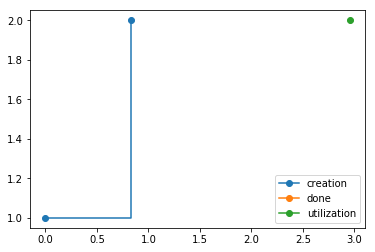

In [90]:
# Balsam metadata
from balsam.core.models import utilization_report, throughput_report, process_job_times, BalsamJob
from matplotlib import pyplot as plt

workflow = "trakem2_test_v3"

##useful stuff
query = BalsamJob.objects.filter(workflow=workflow)
time_dat = process_job_times(query) #filters into a single workflow
[j.runtime_seconds for j in query] # full time per balsam Job

times_created, num_created = sorted(time_dat['CREATED']), range(1, len(time_dat["CREATED"])+1)

t0 = min(times_created)

def mins(t):
    return (t-t0).total_seconds() / 60

plt.step([mins(t) for t in times_created] ,num_created, 'o', where='post',label='creation')
times, num_thru = throughput_report(time_dat)
plt.step([mins(t) for t in times], num_thru,  'o', where='post', label='done')

times_u, num_util = utilization_report(time_dat)
plt.step([mins(t) for t in times_u], num_util, 'o', where='post', label='utilization')
plt.legend()

# Flood Fill Network MultScale Training Job

In [ ]:
#multiscale training job
TFRECORDFILE='/lus/theta-fs0/projects/datascience/keceli/run/f3n/training/tf_record_file'
GROUNDTRUTH='/lus/theta-fs0/projects/datascience/keceli/run/f3n/training/groundtruth.h5'
GRAYSCALE='/lus/theta-fs0/projects/datascience/keceli/run/f3n/training/grayscale_maps.h5'
BATCHSIZE=1
OPTIMIZER='adam'

MAGS = [1,2,4,8,16]

##DOWNSAMPLE INPUT DATA AND ORGANIZE DIRS
#for mag in MAGS:
    
    
for mag in MAGS:    
    TRAINDIR=f'train_b{BATCHSIZE}_o{OPTIMIZER}_m{mag}_{TIMESTAMP}'
    myargs = ''
    myargs += f' --train_coords {TFRECORDFILE} '
    myargs += f' --data_volumes valdation1:{GRAYSCALE}:raw '
    myargs += f' --label_volumes valdation1:{GROUNDTRUTH}:stack '
    myargs += f' --model_name convstack_3d.ConvStack3DFFNModel '
    myargs += ''' --model_args "{\\"depth\\": 12, \\"fov_size\\": [33, 33, 33], \\"deltas\\": [8, 8, 8]}"'''
    myargs += ' --image_mean 128 --image_stddev 33 '
    myargs += ' --max_steps 40000000 --summary_rate_secs 360 ' 
    myargs += f' --batch_size {BATCHSIZE} '
    myargs += f' --optimizer {OPTIMIZER} '
    myargs += ' --num_intra_threads 64 --num_inter_threads 1 '
    myargs += f' --train_dir {TRAINDIR} '

    add_job(name=f'train_mag{mag}',
            workflow='ffn_training',
            application='trainer',
            args=myargs,
            ranks_per_node=rpn,
            num_nodes=nnode,
            environ_vars={'OMP_NUM_THREADS=64'})

# Scratch Space Bellow

In [5]:
# Adding a training job to the database
import time
TFRECORDFILE='/lus/theta-fs0/projects/datascience/keceli/run/f3n/training/tf_record_file'
GROUNDTRUTH='/lus/theta-fs0/projects/datascience/keceli/run/f3n/training/groundtruth.h5'
GRAYSCALE='/lus/theta-fs0/projects/datascience/keceli/run/f3n/training/grayscale_maps.h5'
BATCHSIZE=1
OPTIMIZER='adam'
TIMESTAMP=time.strftime("%y%m%d%H%M%S")
for rpn in [1,4,16]:
    for nnode in [1,4,16,64]:
        TRAINDIR=f'train_b{BATCHSIZE}_o{OPTIMIZER}_n{nnode}_r{rpn}_{TIMESTAMP}'
        myargs = ''
        myargs += f' --train_coords {TFRECORDFILE} '
        myargs += f' --data_volumes valdation1:{GRAYSCALE}:raw '
        myargs += f' --label_volumes valdation1:{GROUNDTRUTH}:stack '
        myargs += f' --model_name convstack_3d.ConvStack3DFFNModel '
        myargs += ''' --model_args "{\\"depth\\": 12, \\"fov_size\\": [33, 33, 33], \\"deltas\\": [8, 8, 8]}"'''
        myargs += ' --image_mean 128 --image_stddev 33 '
        myargs += ' --max_steps 40000000 --summary_rate_secs 360 ' 
        myargs += f' --batch_size {BATCHSIZE} '
        myargs += f' --optimizer {OPTIMIZER} '
        myargs += ' --num_intra_threads 64 --num_inter_threads 1 '
        myargs += f' --train_dir {TRAINDIR} '

        add_job(name=f'train_n{nnode}_r{rpn}',
                workflow='ffn_training',
                application='trainer',
                args=myargs,
                ranks_per_node=rpn,
                num_nodes=nnode,
                environ_vars={'OMP_NUM_THREADS=64'})

In [42]:
##ALIGNTK APPS 

from glob import glob

##TODO jobalize the layers bellow

#!/bin/bash
#COBALT -t 180
#COBALT -n 128
#COBALT -q default
#COBALT -A connectomics_aesp

# NODES=$COBALT_JOBSIZE
# PROC_PER_NODE=64
# PROC=$((NODES * PROC_PER_NODE))
PROC=777

ALIGNTK_DIR="/lus/theta-fs0/projects/connectomics_aesp/software/aligntk-1.0.2/install/bin"
IMAGE_DIR="/lus/theta-fs0/projects/connectomics_aesp/pipeline_data/trakem2_HL00732_run/trakem2_HL00732_process_1/output/"
MASK_DIR="/lus/theta-fs0/projects/connectomics_aesp/pipeline_data/aligntk_HL00732/out1_mask"
OUTPUT_DIR="/lus/theta-fs0/projects/connectomics_aesp/pipeline_data/aligntk_HL00732/out1"
GROUP_SIZE=PROC-1
N_IMAGES= len(glob(IMAGE_DIR+'*'))
N_GROUPS=((N_IMAGES / GROUP_SIZE + 1))


def aligntk_create_dirs(OUTPUT_DIR, MASK_DIR):
    os.mkdir(OUTPUT_DIR)
    os.mkdir(MASK_DIR)
    os.mkdir(OUTPUT_DIR+'/cmaps')
    os.mkdir(OUTPUT_DIR+'/logs')
    os.mkdir(OUTPUT_DIR+'/amaps')
    os.mkdir(OUTPUT_DIR+'/grids')
    os.mkdir(OUTPUT_DIR+'/maps')
    os.mkdir(OUTPUT_DIR+'/aligned')
    

def make_schedule(OUTPUT_DIR):
    
    schedule = ['10   1.0  0.1',
                '9   1.0  0.1',
                '8   1.0  0.3',
                '7   1.0  1.0',
                '7   1.0  2.0',
                '7   1.0  5.0',
                '6   1.0  5.0']
    
    file = open(OUTPUT_DIR+"/schedule.lst","w+") 
    for L in schedule:
        file.writelines(L)
        file.writelines('\n')
    file.close() 
 

In [ ]:
print("Total image count: "+str(N_IMAGES))
print("Number of groups: "+str(N_GROUPS))

#aligntk_create_dirs(OUTPUT_DIR, MASK_DIR)
#make_schedule(OUTPUT_DIR)
#preprocess_main(IMAGE_DIR, OUTPUT_DIR, 12)

from happyneuron.aligntk.preprocess import *

def aligntk_preprocess_job(image_dir, mask_dir, low, high, kernel, workflow)


  #aprun -n 777 -N $PROC_PER_NODE python -m klab_utils.aligntk_gen_mask --image_dir $IMAGE_DIR --mask_dir $MASK_DIR --low 10 --high 240 --kernel 10
      pass

In [ ]:

add_app(name='aligntk_findrst',
        executable='python /lus/theta-fs0/projects/connectomics_aesp/software/HappyNeuron/happyneuron/aligntk/find_rst.py',
        description='AlignTK Apply Map',
        envscript=env_preamble)

def aligntk_rst_job( aligntk=''):

    
    for i in np.arange(N_GROUPS):
#  aprun -n $PROC -N $PROC_PER_NODE $ALIGNTK_DIR/find_rst -pairs pairs$i.lst -tif -images $IMAGE_DIR -mask $MASK_DIR -output $OUTPUT_DIR/cmaps/ -rotation -15-15 -max_res 8192 -scale 0.8-1.2 -tx -30-30 -ty -30-30 -summary $OUTPUT_DIR/cmaps/summary$i.out

    pass

In [52]:
def aligntk_register_job():
    
#
## register
#for (( i=0; i<$N_GROUPS; i++ ))
#do
#  echo "register: $i"
#  START=`date +"%s"`
#  aprun -n $PROC -N $PROC_PER_NODE $ALIGNTK_DIR/register -pairs pairs$i.lst -images $IMAGE_DIR -mask $MASK_DIR -tif -output $OUTPUT_DIR/maps/ -distortion 6.0 -output_level 6 -depth 6 -quality 0.5 -summary $OUTPUT_DIR/maps/summary$i.out -initial_map $OUTPUT_DIR/cmaps/
#	NOW=`date +"%s"`
#	echo $(((NOW - START)/60)) minutes
#done

#echo "register"
#START=`date +"%s"`
#aprun -n $PROC -N $PROC_PER_NODE $ALIGNTK_DIR/register -pairs pairs.lst -images $IMAGE_DIR -mask $MASK_DIR -tif -output $OUTPUT_DIR/maps/ -distortion 4.0 -output_level 6 -depth 6 -quality 0.3 -summary $OUTPUT_DIR/maps/summary.out -initial_map $OUTPUT_DIR/cmaps/
#NOW=`date +"%s"`

    pass

Total image count: 104
Number of groups: 1.134020618556701
{0: ['S_0000',
     'S_0001',
     'S_0002',
     'S_0003',
     'S_0004',
     'S_0005',
     'S_0006',
     'S_0007',
     'S_0008',
     'S_0009',
     'S_0010',
     'S_0011'],
 1: ['S_0011',
     'S_0012',
     'S_0013',
     'S_0014',
     'S_0015',
     'S_0016',
     'S_0017',
     'S_0018',
     'S_0019',
     'S_0020',
     'S_0021',
     'S_0022',
     'S_0023'],
 2: ['S_0023',
     'S_0024',
     'S_0025',
     'S_0026',
     'S_0027',
     'S_0028',
     'S_0029',
     'S_0030',
     'S_0031',
     'S_0032',
     'S_0033',
     'S_0034',
     'S_0035'],
 3: ['S_0035',
     'S_0036',
     'S_0037',
     'S_0038',
     'S_0039',
     'S_0040',
     'S_0041',
     'S_0042',
     'S_0043',
     'S_0044',
     'S_0045',
     'S_0047',
     'S_0051'],
 4: ['S_0051',
     'S_0052',
     'S_0053',
     'S_0057',
     'S_0058',
     'S_0059',
     'S_0061',
     'S_0062',
     'S_0063',
     'S_0064',
     'S_0065',
     'S

In [ ]:
def aligntk_align_job():
## align
#FIXED=`head images.lst -n 1`
# echo "align"
# START=`date +"%s"`
# aprun -n 8192 -N 64 $ALIGNTK_DIR/align -images $IMAGE_DIR -image_list images.lst -map_list pairs.lst -maps $OUTPUT_DIR/maps/ -masks $MASK_DIR -output $OUTPUT_DIR/amaps/ -schedule schedule.lst -incremental -output_grid $OUTPUT_DIR/grids/ -grid_size 8192x8192 -fold_recovery 60
#aprun -n $PROC -N $PROC_PER_NODE $ALIGNTK_DIR/align -images $IMAGE_DIR -image_list images.lst -map_list pairs.lst -masks $MASK_DIR -maps $OUTPUT_DIR/maps/ -output $OUTPUT_DIR/amaps/ -schedule schedule.lst -incremental -output_grid $OUTPUT_DIR/grids/ -grid_size 8192x8192 -fold_recovery 60
# NOW=`date +"%s"`
# echo $(((NOW - START)/60)) minutes
    pass

In [ ]:
def aligntk_applymap_job():
#START=`date +"%s"`
##$ALIGNTK_DIR/apply_map -image_list images.lst -images $IMAGE_DIR -maps $OUTPUT_DIR/amaps/ -output $OUTPUT_DIR/aligned/ -memory 150000
#aprun -n 777 -N 64 python -m klab_utils.aligntk_mpi_apply_map ./outputs_v1/ --image_dir ../data/images_corr_v2/ --image_lst ./images.lst
#
#NOW=`date +"%s"`
#echo $(((NOW - START)/60)) minutes
    pass